<a href="https://colab.research.google.com/github/granados-pastrana/Machine-Learning-Industry-Aplications/blob/main/02_credit_card_fraud_detection_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Card Fraud Detection using Autoencoders
- ML Methods used:
  - Autoencoders (To Anomaly Detection)

    - Train a Autoencoder architecture to try to reproduce the original labels
    - Those transactions with a larger error are considered fraudulent.
    - An Autoencoder's threshold will be set, based on the correct detection of fraudulent transactions.
    - Will be used a trade-off curve Precision vs Recall to set such Autoencoder's threshold


### Business Case Statement
- The ABC Bank wants to identify the fraudulent transactions in real time. For this reason it provided a dataset with historical Legal and Fraudulent transactions to train a model and set it in production.
- Data Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [3]:

import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, precision_recall_curve

np.random.seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path_data = 'Colab Notebooks/ML+/02_credit_card_fraud_detection/'
file_name = '02_credit_card_fraud_dataset.csv'
df_creditcard = pd.read_csv('/content/drive/My Drive/' + path_data + file_name)

Mounted at /content/drive


In [8]:
df_creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Total Legal_Transactions & Fraud_Transactions
0    142157
1       492
Name: Class, dtype: int64


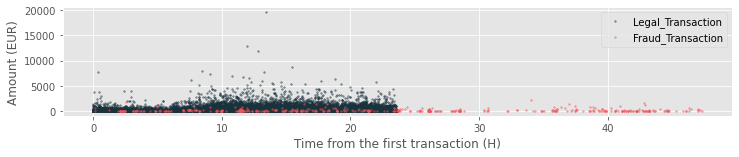

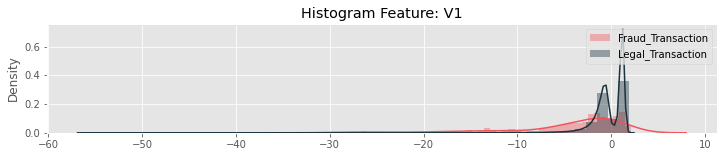

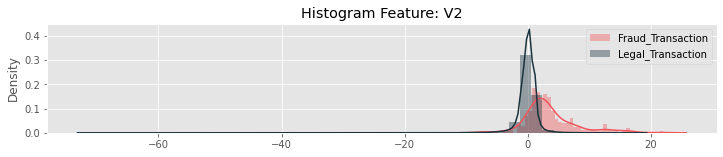

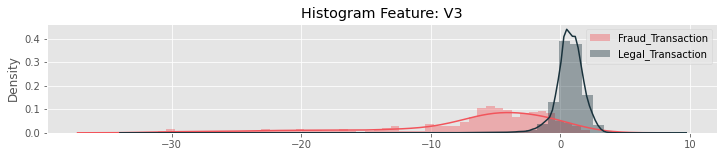

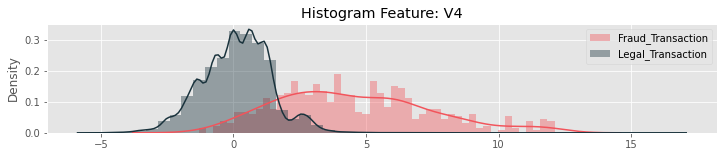

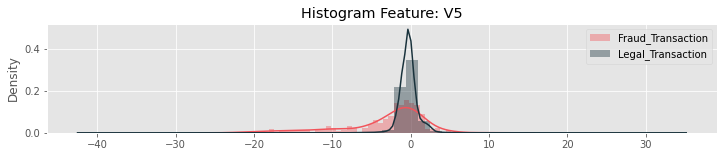

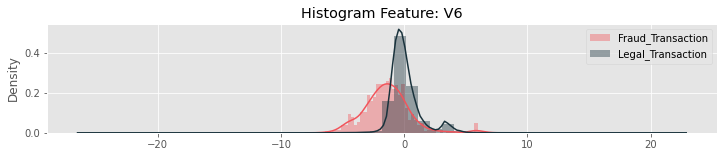

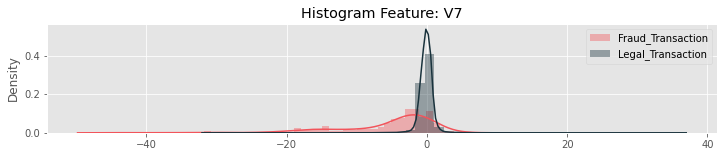

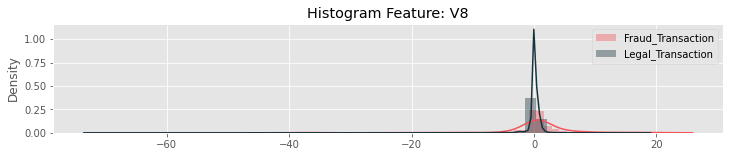

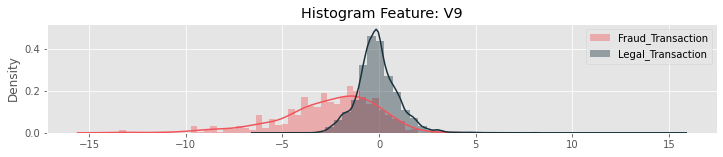

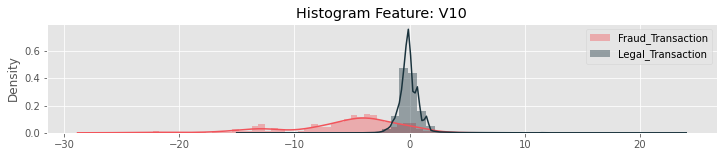

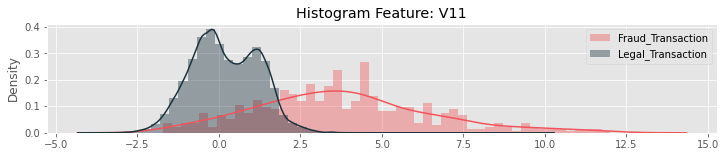

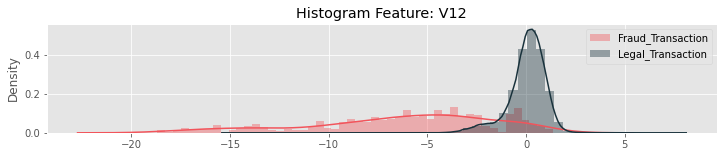

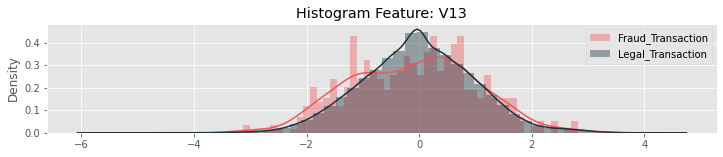

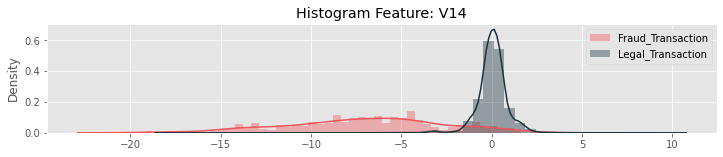

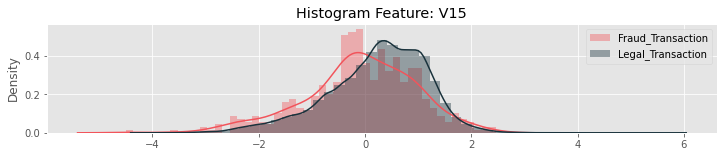

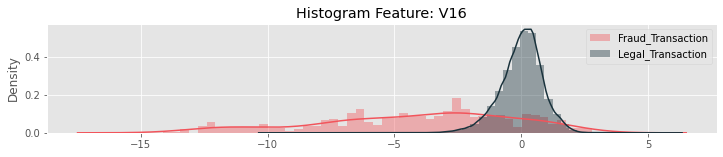

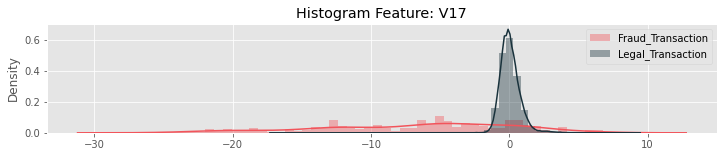

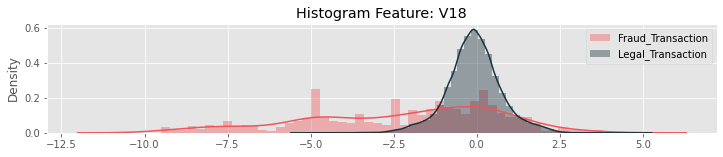

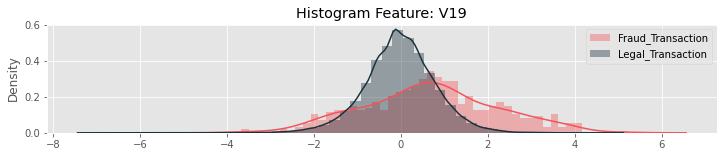

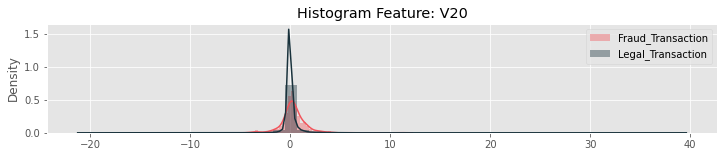

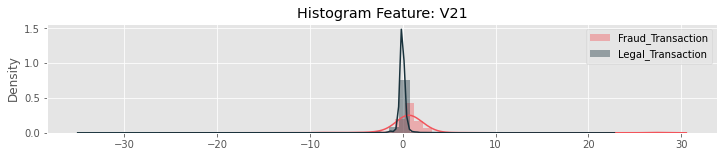

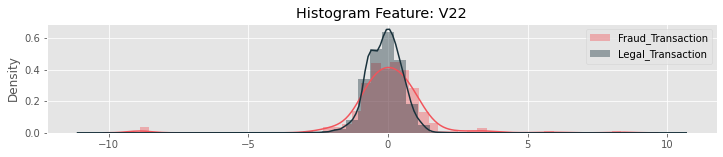

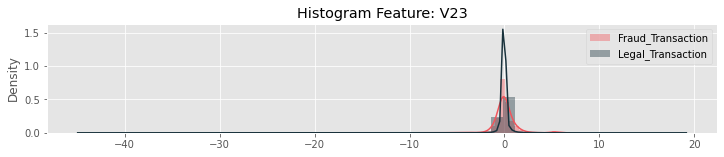

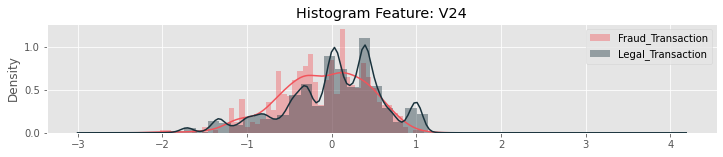

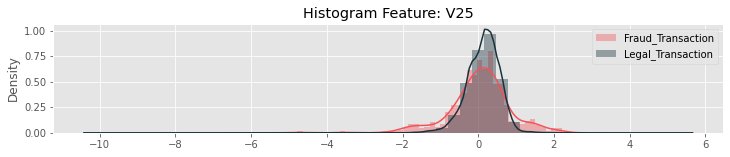

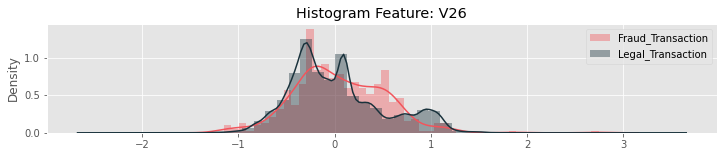

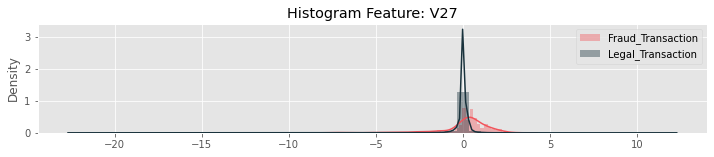

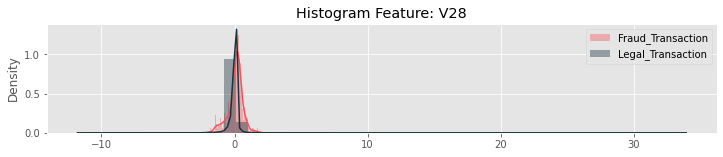

In [21]:
# 2. FEATURE DISTRIBUTION ANALYSIS
# ============================================================================

# Total Legal_Transactions & Fraud_Transactions
nr_clases = df_creditcard['Class'].value_counts(sort=True)
print('Total Legal_Transactions & Fraud_Transactions')
print(nr_clases)

# Transaction_Amounts vs Time
normales = df_creditcard[df_creditcard.Class==0]
fraudulentos = df_creditcard[df_creditcard.Class==1]

plt.subplots(figsize = (12, 2))
plt.scatter(normales.Time/3600, normales.Amount, 
	alpha = 0.5, c='#19323C', label='Legal_Transaction', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, 
	alpha = 0.5, c='#F2545B', label='Fraud_Transaction', s=3)
plt.xlabel('Time from the first transaction (H)')
plt.ylabel('Amount (EUR)')
plt.legend(loc='upper right')
plt.show()


# Fraud and non-Fraud Features Distribution
v_1_28 = df_creditcard.iloc[:,1:29].columns
gs = gridspec.GridSpec(28, 1)

for i, cn in enumerate(df_creditcard[v_1_28]):
    plt.subplots(figsize = (12, 2))
    sns.distplot(df_creditcard[cn][df_creditcard.Class == 1], bins=50, 
    	label='Fraud_Transaction', color='#F2545B')
    sns.distplot(df_creditcard[cn][df_creditcard.Class == 0], bins=50, 
    	label='Legal_Transaction', color='#19323C')
    plt.xlabel('')
    plt.title('Histogram Feature: ' + str(cn))
    plt.legend(loc='upper right')
    plt.show()


In [22]:
# 3. PRE-PROCESSING
# ============================================================================
# Drop Time Variable
df_creditcard.drop(['Time'], axis=1, inplace=True)

# Scale dataset
df_creditcard['Amount'] = StandardScaler().fit_transform(df_creditcard['Amount'].values.reshape(-1,1))

# Split Dataset
X_train, X_test = train_test_split(df_creditcard, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

In [25]:
# 4. AUTOENCODER: 
#   Architecture:          29     20    14    20   29 
#   Activation Functions: input -tanh -relu- tanh -relu(output)
# ============================================================================

dim_input = X_train.shape[1]          # 29 (because 29 features)
layer_input = Input(shape=(dim_input,))

# Autoencoder Architecture
encoder = Dense(20, activation='tanh')(layer_input)
encoder = Dense(14, activation='relu')(encoder)

decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=layer_input, outputs=decoder)

# Cost Function
sgd = SGD(lr=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

# Training
epochs = 50 # n_iterations
batch_size = 32
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test,X_test), verbose=1)

Epoch 1/50
3554/3554 [==============================] - 12s 3ms/step - loss: 0.9231 - val_loss: 0.9034
Epoch 2/50
3554/3554 [==============================] - 8s 2ms/step - loss: 0.8229 - val_loss: 0.8347
Epoch 3/50
3554/3554 [==============================] - 15s 4ms/step - loss: 0.7773 - val_loss: 0.8086
Epoch 4/50
3554/3554 [==============================] - 6s 2ms/step - loss: 0.7578 - val_loss: 0.7943
Epoch 5/50
3554/3554 [==============================] - 6s 2ms/step - loss: 0.7452 - val_loss: 0.7835
Epoch 6/50
3554/3554 [==============================] - 6s 2ms/step - loss: 0.7352 - val_loss: 0.7744
Epoch 7/50
3554/3554 [==============================] - 6s 2ms/step - loss: 0.7266 - val_loss: 0.7665
Epoch 8/50
3554/3554 [==============================] - 6s 2ms/step - loss: 0.7190 - val_loss: 0.7593
Epoch 9/50
3554/3554 [==============================] - 6s 2ms/step - loss: 0.7108 - val_loss: 0.7499
Epoch 10/50
3554/3554 [==============================] - 9s 3ms/step - loss: 0.6

(28530, 29)


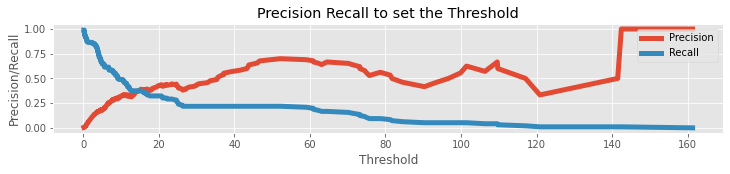

Optimizing Precision
       Legal_pred  Fraud_pred
Legal       28424          10
Fraud          75          21
21% predicted Frauds correctly

Optimizing Recall
***WINER Threshold***
       Legal_pred  Fraud_pred
Legal       24985        3449
Fraud           9          87

Results:
Optimizing the Recall we predict correctly a grater number of fraud transactinos, a 90% in "test dataset"!!


In [50]:
# 5. VALIDATION
# ============================================================================

# Prediction X_test -> Autoencoder -> X_pred
X_pred = autoencoder.predict(X_test)

# Error Calc MSE
mse = np.mean(np.power(X_test-X_pred,2), axis=1)
print(X_pred.shape)

# Chart: precision-recall, to determine the threshold
precision, recall, threshold = precision_recall_curve(Y_test, mse)

plt.subplots(figsize = (12, 2))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision Recall to set the Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# FINAL REPORT & CONCLUSION
# Confusion Matrix (Optimizing Precision)
threshold_fijo = 50
Y_pred = [1 if e > threshold_fijo else 0 for e in mse]
conf_matrix = confusion_matrix(Y_test, Y_pred)
print('Optimizing Precision')
print(pd.DataFrame(conf_matrix, columns=['Legal_pred', 'Fraud_pred'], index=['Legal', 'Fraud']))
print('21% predicted Frauds correctly')

# Confusion Matrix (Optimizing Recall)
threshold_fijo = 0.75
Y_pred = [1 if e > threshold_fijo else 0 for e in mse]
conf_matrix = confusion_matrix(Y_test, Y_pred)
print('\nOptimizing Recall')
print('***WINER Threshold***')
print(pd.DataFrame(conf_matrix, columns=['Legal_pred', 'Fraud_pred'], index=['Legal', 'Fraud']))
print('\nResults:\n', '===='*10)
print('Optimizing the Recall we predict correctly a grater number of fraud transactinos, a 90% in "test dataset"!!')
print('===='*10)